In [1]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
df_fx_data = pd.read_csv('BOE-XUDLERD.csv')
df_fx_data

,Date,Value
0,2017-11-09,0.8603
1,2017-11-08,0.8631
2,2017-11-07,0.8639
3,2017-11-06,0.8631
4,2017-11-03,0.8608
...,...,...
10832,1975-01-08,0.7554
10833,1975-01-07,0.7510
10834,1975-01-06,0.7524
10835,1975-01-03,0.7585


In [3]:
df_fx_data['Date'] = pd.to_datetime(df_fx_data['Date'])
indexed_df = df_fx_data.set_index('Date')
ts = indexed_df['Value']
ts.head(5)

Date
2017-11-09    0.8603
2017-11-08    0.8631
2017-11-07    0.8639
2017-11-06    0.8631
2017-11-03    0.8608
Name: Value, dtype: float64

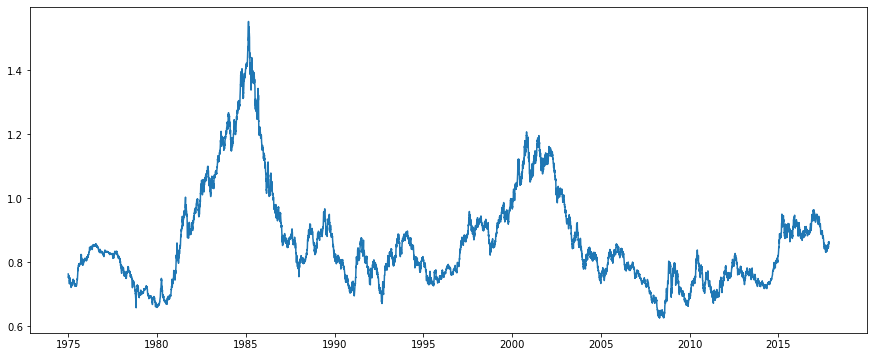

In [4]:
plt.plot(ts)

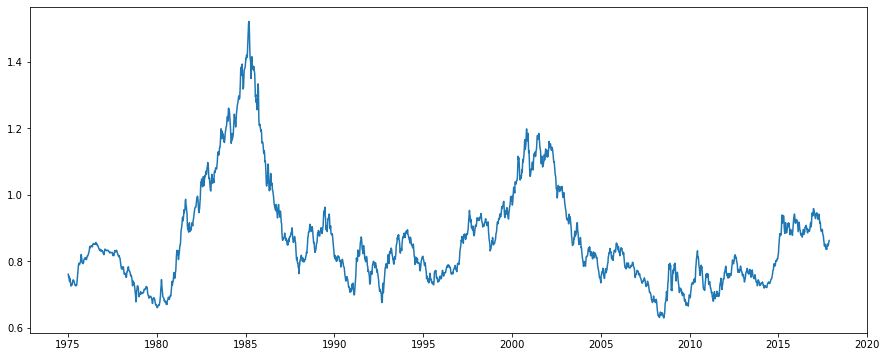

In [5]:
ts_week = ts.resample('W').mean()
plt.plot(ts_week)

In [50]:
len(ts_week)

2237

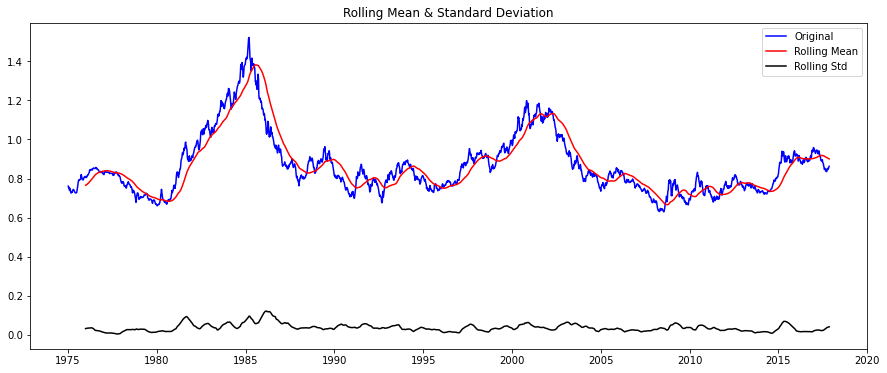

Results of Dickey-Fuller Test:
Test Statistic                   -2.076341
p-value                           0.254134
#Lags Used                        2.000000
Number of Observations Used    2234.000000
Critical Value (1%)              -3.433281
Critical Value (5%)              -2.862835
Critical Value (10%)             -2.567459
dtype: float64


In [6]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(ts_week)

In [39]:
ts_week - ts_week.shift()

Date
1975-01-05        NaN
1975-01-12   -0.00744
1975-01-19    0.00200
1975-01-26   -0.01158
1975-02-02   -0.00486
               ...   
2017-10-15   -0.00554
2017-10-22    0.00170
2017-10-29    0.00528
2017-11-05    0.00610
2017-11-12    0.00324
Freq: W-SUN, Name: Value, Length: 2237, dtype: float64

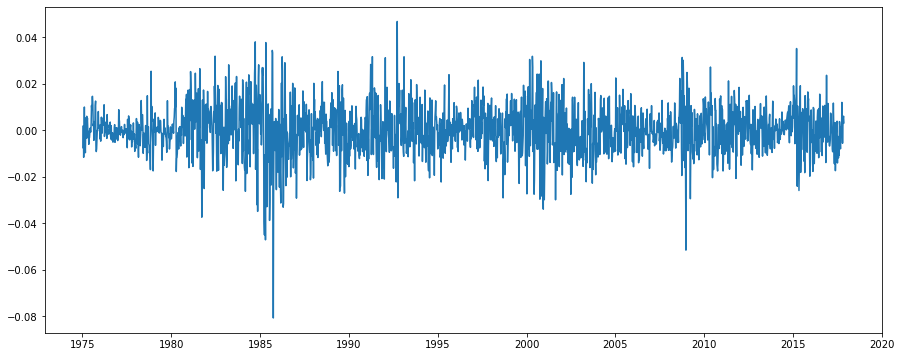

In [51]:
#ts_week_log = np.log(ts_week)
ts_week_diff = ts_week - ts_week.shift()
plt.plot(ts_week_diff)

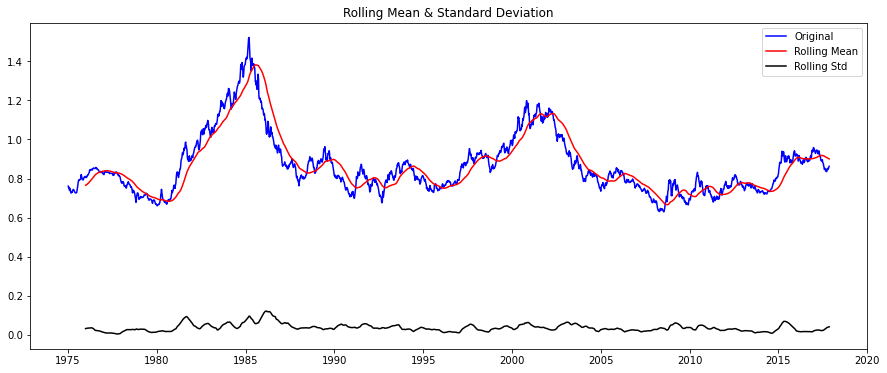

Results of Dickey-Fuller Test:
Test Statistic                   -2.076341
p-value                           0.254134
#Lags Used                        2.000000
Number of Observations Used    2234.000000
Critical Value (1%)              -3.433281
Critical Value (5%)              -2.862835
Critical Value (10%)             -2.567459
dtype: float64


In [56]:
ts_week.dropna(inplace=True)
test_stationarity(ts_week)

In [59]:
#ACF and PACF
lag_acf = acf(ts_week, nlags=100)
lag_pacf = pacf(ts_week, nlags=100, method='ols')

C:\Users\MADHAV\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Autocorrelation Function')

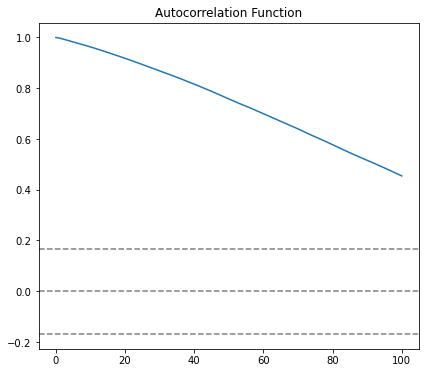

In [60]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

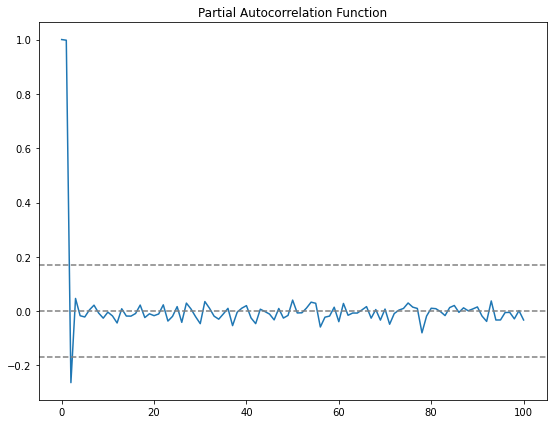

In [61]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Text(0.5, 1.0, 'RSS: 0.2277')

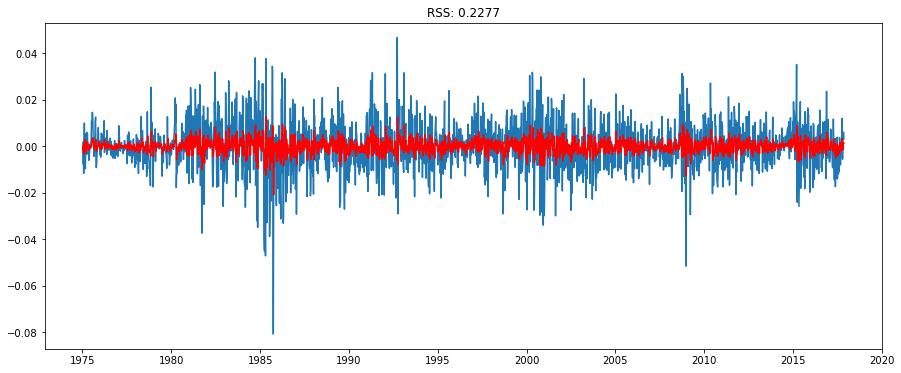

In [15]:
model = ARIMA(ts_week, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_week_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_week_diff)**2))

In [ ]:
model = ARIMA(ts_week, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 2236
Model:                 ARIMA(2, 1, 1)   Log Likelihood                7103.859
Method:                       css-mle   S.D. of innovations              0.010
Date:                Wed, 21 Oct 2020   AIC                         -14197.718
Time:                        21:14:18   BIC                         -14169.156
Sample:                    01-12-1975   HQIC                        -14187.290
                         - 11-12-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.468e-05      0.000      0.161      0.872      -0.000       0.001
ar.L1.D.Value     0.1121      0.311      0.360      0.719      -0.498       0.723
ar.L2.D.Value    -0.0068      0.086     

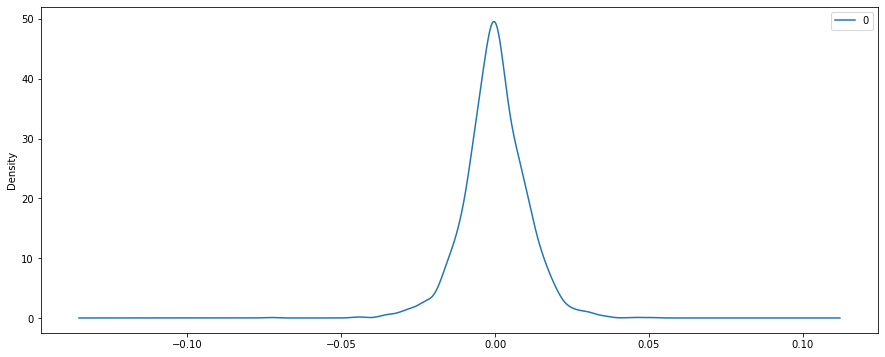

In [16]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [17]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
1975-01-12    0.000045
1975-01-19   -0.001914
1975-01-26    0.000950
1975-02-02   -0.003312
1975-02-09   -0.000678
Freq: W-SUN, dtype: float64


Text(0.5, 1.0, 'RMSE: 0.1308')

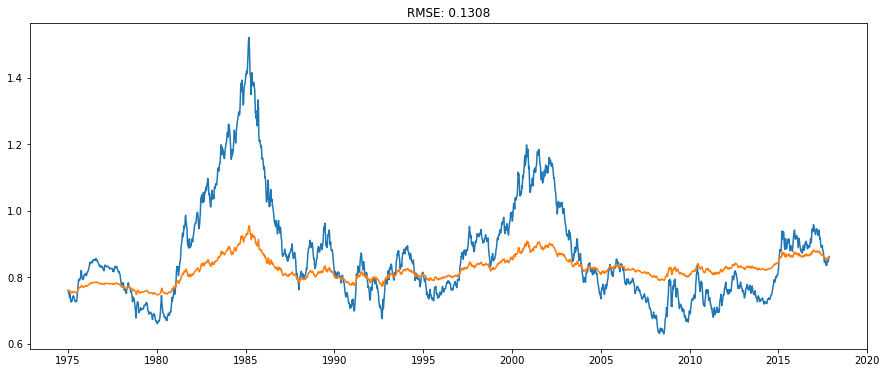

In [28]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA = pd.Series(ts_week[0], index=ts_week.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum,fill_value=0)                       
#predictions_ARIMA = np.exp(predictions_ARIMA)
plt.plot(ts_week)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_week)**2)/len(ts_week)))

In [29]:
size = int(len(ts_week) - 15)
train, test = ts_week[0:size], ts_week[size:len(ts_week)]
history = [x for x in train]
predictions = list()

In [32]:
size = int(len(ts_week) - 15)
train, test = ts_week[0:size], ts_week[size:len(ts_week)]
history = [x for x in train]
predictions = list()
print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' %(yhat, obs))

Printing Predicted vs Expected Values...


predicted=0.855605, expected=0.846240
predicted=0.843588, expected=0.850020
predicted=0.851594, expected=0.851780
predicted=0.852020, expected=0.846460
predicted=0.844981, expected=0.838525
predicted=0.836649, expected=0.836180
predicted=0.835922, expected=0.837640
predicted=0.838130, expected=0.835860
predicted=0.835310, expected=0.847900
predicted=0.851344, expected=0.851820
predicted=0.852295, expected=0.846280
predicted=0.844687, expected=0.847980
predicted=0.848778, expected=0.853260
predicted=0.854605, expected=0.859360
predicted=0.860821, expected=0.862600


In [36]:
history

[0.7608999999999999,
 0.75346,
 0.75546,
 0.74388,
 0.73902,
 0.7490600000000001,
 0.74142,
 0.73538,
 0.7257800000000001,
 0.7266800000000001,
 0.73212,
 0.7286800000000001,
 0.73475,
 0.737675,
 0.74296,
 0.74428,
 0.74106,
 0.7406200000000001,
 0.7346199999999999,
 0.73122,
 0.72814,
 0.7268749999999999,
 0.72782,
 0.72736,
 0.7266600000000001,
 0.7298199999999999,
 0.7405,
 0.74948,
 0.764,
 0.77864,
 0.78942,
 0.7914,
 0.7943,
 0.79002,
 0.7938,
 0.79542,
 0.7971799999999999,
 0.80794,
 0.82054,
 0.8142799999999999,
 0.8051600000000001,
 0.7971999999999999,
 0.79362,
 0.79364,
 0.79342,
 0.79638,
 0.8044799999999999,
 0.8066800000000001,
 0.8076800000000001,
 0.8098599999999999,
 0.81088,
 0.8071666666666667,
 0.8094,
 0.8047599999999999,
 0.80686,
 0.81254,
 0.81624,
 0.81504,
 0.81836,
 0.82226,
 0.82446,
 0.8299199999999999,
 0.8336399999999999,
 0.84466,
 0.8420400000000001,
 0.8408200000000001,
 0.8431799999999999,
 0.8466750000000001,
 0.8459500000000001,
 0.8472,
 0.84702,


In [37]:
error = mean_squared_error(test, predictions)
print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)
predictions_series = pd.Series(predictions, index = test.index)



Printing Mean Squared Error of Predictions...
Test MSE: 0.000031


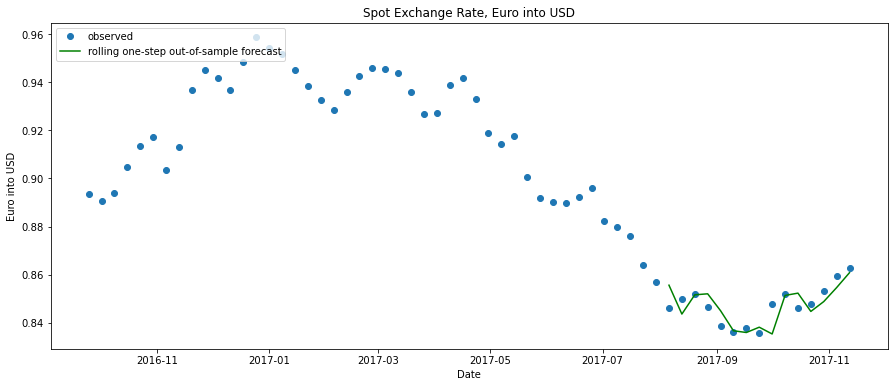

In [38]:
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(ts_week[-60:], 'o', label='observed')
ax.plot(predictions_series, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')